If you're opening this Notebook on colab, you will probably need to install 🤗 Transformers and 🤗 Datasets. Uncomment the following cell and run it.

In [1]:
# pip install datasets transformers scipy==1.5.0

In [3]:
%load_ext rpy2.ipython
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

In [20]:
%%R
# Uncomment if uninstalled locally
# install.packages('lme4')
# install.packages('MuMIn')
# install.packages('lmerTest')
# install.packages('ggplot2')

/home/tpimentel/anaconda3/envs/measure-uid/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://cran.mirror.garr.it/CRAN/src/contrib/lme4_1.1-26.tar.gz'

  warnings.warn(x, RRuntimeWarning)
/home/tpimentel/anaconda3/envs/measure-uid/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/octet-stream'
  warnings.warn(x, RRuntimeWarning)
/home/tpimentel/anaconda3/envs/measure-uid/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3297635 bytes (3.1 MB)

  warnings.warn(x, RRuntimeWarning)
/home/tpimentel/anaconda3/envs/measure-uid/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: =
  warnings.warn(x, RRuntimeWarning)
/home/tpimentel/anaconda3/envs/measure-uid/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)
/home/tpimentel/anaconda3/envs/measure-uid/lib/python3.7/site

/home/tpimentel/anaconda3/envs/measure-uid/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://cran.mirror.garr.it/CRAN/src/contrib/MuMIn_1.43.17.tar.gz'

  warnings.warn(x, RRuntimeWarning)
/home/tpimentel/anaconda3/envs/measure-uid/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Warning message:

  warnings.warn(x, RRuntimeWarning)
/home/tpimentel/anaconda3/envs/measure-uid/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: In install.packages("lme4") :
  warnings.warn(x, RRuntimeWarning)
/home/tpimentel/anaconda3/envs/measure-uid/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
 
  warnings.warn(x, RRuntimeWarning)
/home/tpimentel/anaconda3/envs/measure-uid/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  installation of package ‘lme4’ had non-zero exit status

  warnings.warn(x, RRuntimeWarning)


If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

You can find a script version of this notebook to fine-tune your model in a distributed fashion using multiple GPUs or TPUs [here](https://github.com/huggingface/transformers/tree/master/examples/language-modeling).

In [5]:
import math
import torch
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import numpy as np


# Initializing a model 
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.eval()
# Load pre-trained model tokenizer (vocabulary)
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')

#TODO: give context window when string is bigger than max length
def score(sentence):
  with torch.no_grad():
    all_log_probs = []
    offset_mapping = []
    start_ind = 0
    
    while True:
      encodings = tokenizer(sentence[start_ind:], max_length=1022, truncation=True, return_offsets_mapping=True)
      # Convert indexed tokens in a PyTorch tensor
      tensor_input = torch.tensor([[tokenizer.bos_token_id] + encodings['input_ids'] + [tokenizer.eos_token_id]])
      output = model(tensor_input, labels=tensor_input)
      shift_logits = output['logits'][..., :-1, :].contiguous()
      shift_labels = tensor_input[..., 1:].contiguous()
      log_probs = torch.nn.functional.cross_entropy(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1), reduction='none')
      assert math.exp(sum(log_probs)/len(log_probs)) == math.exp(output['loss'])
      all_log_probs.extend(log_probs[:-1])
      offset_mapping.extend([(i+start_ind, j+start_ind) for i,j in encodings['offset_mapping']])
      if encodings['offset_mapping'][-1][1] + start_ind == len(sentence):
        break
      start_ind = encodings['offset_mapping'][-1][1]
    return np.asarray(all_log_probs), offset_mapping


In [6]:
# Test for above function
a=['there is a book on the desk',
                'there is a plane on the desk',
                        'there is a book in the desk']
print([score(i) for i in a])

[(array([ 9.57189  ,  1.354045 ,  1.4517236,  6.623471 ,  2.2267733,
        2.0630045, 10.367743 ], dtype=float32), [(0, 5), (5, 8), (8, 10), (10, 15), (15, 18), (18, 22), (22, 27)]), (array([9.57189  , 1.354045 , 1.4517236, 9.536716 , 3.2394037, 0.7227517,
       8.800835 ], dtype=float32), [(0, 5), (5, 8), (8, 10), (10, 16), (16, 19), (19, 23), (23, 28)]), (array([ 9.57189  ,  1.354045 ,  1.4517236,  6.623471 ,  3.4382677,
        1.2431318, 11.079843 ], dtype=float32), [(0, 5), (5, 8), (8, 10), (10, 15), (15, 18), (18, 22), (22, 27)])]


In [14]:
import pandas as pd
reading_times_df = pd.read_csv("../data/reading_times.tsv", sep='\t').drop_duplicates()
gpt3_probs = pd.read_csv("../data/surprisals.csv")
gpt3_probs["story"] = gpt3_probs["story"] + 1

In [ ]:
reading_times_df.head()

,WorkerId,WorkTimeInSeconds,correct,item,zone,RT,word,nItem,meanItemRT,sdItemRT,gmeanItemRT,gsdItemRT
0,A3QJPB0NZU5PY1,3960,6,1,1,924,If,84,369.011905,160.579935,340.566023,1.490513
1,A2RPQGUWVZPX7U,2431,5,1,1,474,If,84,369.011905,160.579935,340.566023,1.490513
2,A11KMPAZSE5Q0Q,1287,5,1,1,272,If,84,369.011905,160.579935,340.566023,1.490513
3,A1U1QL617G5DU3,2074,6,1,1,354,If,84,369.011905,160.579935,340.566023,1.490513
4,ACTW5YEWV9OR0,2213,6,1,1,577,If,84,369.011905,160.579935,340.566023,1.490513


In [15]:
gpt3_probs[gpt3_probs.story==1].head(n=10)

,token,logprob,offset,model,time,id,story
0,If,NaN,0,davinci:2020-05-03,1614358345,cmpl-2XadldozPyY3qBl3GxvbDAX8XOE6V,1
1,you,-0.776271,2,davinci:2020-05-03,1614358345,cmpl-2XadldozPyY3qBl3GxvbDAX8XOE6V,1
2,were,-4.331911,6,davinci:2020-05-03,1614358345,cmpl-2XadldozPyY3qBl3GxvbDAX8XOE6V,1
3,to,-1.461822,11,davinci:2020-05-03,1614358345,cmpl-2XadldozPyY3qBl3GxvbDAX8XOE6V,1
4,journey,-10.098377,14,davinci:2020-05-03,1614358345,cmpl-2XadldozPyY3qBl3GxvbDAX8XOE6V,1
5,to,-1.281663,22,davinci:2020-05-03,1614358345,cmpl-2XadldozPyY3qBl3GxvbDAX8XOE6V,1
6,the,-0.959809,25,davinci:2020-05-03,1614358345,cmpl-2XadldozPyY3qBl3GxvbDAX8XOE6V,1
7,North,-4.631145,29,davinci:2020-05-03,1614358345,cmpl-2XadldozPyY3qBl3GxvbDAX8XOE6V,1
8,of,-3.359971,35,davinci:2020-05-03,1614358345,cmpl-2XadldozPyY3qBl3GxvbDAX8XOE6V,1
9,England,-1.629911,38,davinci:2020-05-03,1614358345,cmpl-2XadldozPyY3qBl3GxvbDAX8XOE6V,1


In [16]:
gpt3_probs['len'] = gpt3_probs.groupby("story", sort=False)['offset'].shift(periods=-1, fill_value=0) - gpt3_probs['offset'] 
gpt3_probs['new_token'] = gpt3_probs.apply(lambda x: x['token'] if x['len'] == len(x['token']) else x['token'] + ' ', axis=1) 

In [17]:
# this one takes ~30 seconds to run with the call to "score"
import nltk
nltk.download('punkt')
def string_join(x):
    return ''.join(x)

def get_word_mapping(words):
  offsets = []
  pos = 0
  for w in words:
    offsets.append((pos,pos+len(w)))
    pos += len(w) + 1
  return offsets

def string_to_log_probs(string, probs, offsets):
  words = string.split()
  agg_log_probs = []
  word_mapping = get_word_mapping(words)
  cur_prob = 0
  cur_word_ind = 0
  for lp, ind in zip(probs, offsets):
    cur_prob += lp
    if ind[1] == word_mapping[cur_word_ind][1]:
      agg_log_probs.append(cur_prob)
      cur_prob = 0
      cur_word_ind += 1
  return agg_log_probs
  
stories_df = gpt3_probs.groupby(by=["story"], sort=False).agg({"new_token":[string_join]}).reset_index()
stories = {}
stories_sent_markers = {}
log_probs = {}
agg_log_probs = {}
for i, s in zip(stories_df['story'], stories_df['new_token', 'string_join']):
  # remove trailing white space
  s = s[:-1]
  stories_sent_markers[i] = np.cumsum([len(sen.split()) for sen in nltk.sent_tokenize(s)])
  stories[i] = s.split()
  log_probs[i] = score(s)
  agg_log_probs[i] = string_to_log_probs(s, log_probs[i][0],log_probs[i][1]) 

[nltk_data] Downloading package punkt to /home/tpimentel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
import bisect
reading_times_df['ref_token'] = reading_times_df.apply(lambda x: stories[x['item']][x['zone']-1], axis=1)
reading_times_df['log_prob'] = reading_times_df.apply(lambda x: agg_log_probs[x['item']][x['zone']-1], axis=1)
reading_times_df['sentence_num'] = reading_times_df.apply(lambda x: bisect.bisect(stories_sent_markers[x['item']], x['zone']-1), axis=1)
reading_times_df['word_len'] = reading_times_df.apply(lambda x: len(x['word']), axis=1)

In [19]:
# sanity check: looks like there's a small mispelling somewhere ;)
reading_times_df[reading_times_df['word'] != reading_times_df['ref_token']]

,WorkerId,WorkTimeInSeconds,correct,item,zone,RT,word,nItem,meanItemRT,sdItemRT,gmeanItemRT,gsdItemRT,ref_token,log_prob,sentence_num,word_len
159123,A2TG01V56PAL65,1669,6,2,749,187,peaked,90,359.355556,136.944942,336.503634,1.434533,peeked,8.330512,28,6
159124,A2EAIMII6MSIO5,2303,6,2,749,323,peaked,90,359.355556,136.944942,336.503634,1.434533,peeked,8.330512,28,6
159125,A3NMC1E54BML7K,3004,5,2,749,400,peaked,90,359.355556,136.944942,336.503634,1.434533,peeked,8.330512,28,6
159126,A11AUVZ4MCA7VU,1992,6,2,749,300,peaked,90,359.355556,136.944942,336.503634,1.434533,peeked,8.330512,28,6
159127,A117RW2F1MNBQ8,2792,6,2,749,330,peaked,90,359.355556,136.944942,336.503634,1.434533,peeked,8.330512,28,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159208,A1H314LD953G5Q,2242,6,2,749,282,peaked,90,359.355556,136.944942,336.503634,1.434533,peeked,8.330512,28,6
159209,ACTW5YEWV9OR0,2213,6,2,749,255,peaked,90,359.355556,136.944942,336.503634,1.434533,peeked,8.330512,28,6
159210,ALE5RDP8XZL3,3805,6,2,749,590,peaked,90,359.355556,136.944942,336.503634,1.434533,peeked,8.330512,28,6
159211,AKEZ83FQITFD8,4715,6,2,749,224,peaked,90,359.355556,136.944942,336.503634,1.434533,peeked,8.330512,28,6


In [21]:
# Commented this out since lmer does this
# # subtract mean reader time (per reader)
# reading_times_df['RT'] -= reading_times_df.groupby(by=["WorkerId"]).transform('mean')["RT"] #agg({"RT": [np.sum, np.mean, np.std], "log_prob": [np.sum, np.mean, np.std]})

In [23]:
%R -i reading_times_df

AttributeError: type object 'DataFrame' has no attribute 'from_items'

In [ ]:
%%R
library(lme4)
library(MuMIn)

In [ ]:
%%R
model <- lmer("RT~log_prob + word_len + (1 | WorkerId)", data=reading_times_df)
summary(model)

Linear mixed model fit by REML ['lmerMod']
Formula: RT ~ log_prob + word_len + (1 | WorkerId)
   Data: reading_times_df

REML criterion at convergence: 10916104

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7805 -0.4460 -0.1740  0.1567 18.4691 

Random effects:
 Groups   Name        Variance Std.Dev.
 WorkerId (Intercept)  7027     83.83  
 Residual             22482    149.94  
Number of obs: 848852, groups:  WorkerId, 180

Fixed effects:
             Estimate Std. Error t value
(Intercept) 303.31382    6.27318   48.35
log_prob      3.15544    0.06125   51.52
word_len      4.03173    0.07935   50.81

Correlation of Fixed Effects:
         (Intr) lg_prb
log_prob -0.010       
word_len -0.040 -0.478


In [ ]:
from scipy.special import log_softmax
def ent(x):
  l_soft = log_softmax(-x)
  return -sum(np.exp(l_soft)*l_soft)
def norm_ent(x):
  return ent(x)/np.log(len(x))
aggregate_per_sentence = reading_times_df.groupby(by=["WorkerId","item", "sentence_num"], sort=False).agg({"RT": [np.sum, np.mean, np.count_nonzero], "log_prob": [np.sum, np.mean, np.var, ent, norm_ent], "word_len":np.sum}).reset_index()
aggregate_per_sentence.columns = ['_'.join(col).strip() for col in aggregate_per_sentence.columns.values]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [ ]:
aggregate_per_sentence.corr()

,item_,sentence_num_,RT_sum,RT_mean,RT_count_nonzero,log_prob_sum,log_prob_mean,log_prob_var,log_prob_ent,log_prob_norm_ent,word_len_sum
item_,1.000000,-0.062953,0.048143,0.035593,0.032914,0.037053,-0.021106,0.035509,0.031581,0.007996,0.183475
sentence_num_,-0.062953,1.000000,-0.210498,-0.121445,-0.171977,-0.148340,0.045936,0.021018,-0.170928,-0.122687,-0.176466
RT_sum,0.048143,-0.210498,1.000000,0.474653,0.828290,0.791488,-0.109171,0.015888,0.716075,0.389378,0.805786
RT_mean,0.035593,-0.121445,0.474653,1.000000,-0.001727,0.028477,0.097815,0.075659,-0.033146,-0.054057,0.021103
RT_count_nonzero,0.032914,-0.171977,0.828290,-0.001727,1.000000,0.932750,-0.165086,-0.026784,0.879085,0.494102,0.954221
log_prob_sum,0.037053,-0.148340,0.791488,0.028477,0.932750,1.000000,0.058593,0.179918,0.733587,0.317222,0.927655
log_prob_mean,-0.021106,0.045936,-0.109171,0.097815,-0.165086,0.058593,1.000000,0.616645,-0.371066,-0.584444,-0.101990
log_prob_var,0.035509,0.021018,0.015888,0.075659,-0.026784,0.179918,0.616645,1.000000,-0.189830,-0.372641,0.050796
log_prob_ent,0.031581,-0.170928,0.716075,-0.033146,0.879085,0.733587,-0.371066,-0.189830,1.000000,0.792224,0.805049
log_prob_norm_ent,0.007996,-0.122687,0.389378,-0.054057,0.494102,0.317222,-0.584444,-0.372641,0.792224,1.000000,0.420948


In [ ]:
%R -i aggregate_per_sentence

In [ ]:
%%R
model1 <- lmer(RT_sum~ log_prob_sum  + (1 | WorkerId_), data=aggregate_per_sentence)
model2 <- lmer(RT_sum~ word_len_sum  + (1 | WorkerId_), data=aggregate_per_sentence)
model3 <- lmer(RT_sum~ word_len_sum +log_prob_sum + (1 | WorkerId_), data=aggregate_per_sentence)
print("Conditional R^2:")
print(r.squaredGLMM(model1)[1])
print(r.squaredGLMM(model2)[1])
print(r.squaredGLMM(model3)[1])

[1] "Conditional R^2:"
[1] 0.6307972
[1] 0.6569172
[1] 0.669113


In [ ]:
%%R
model1 <- lmer(RT_sum~ log_prob_sum  + (1 | WorkerId_), data=aggregate_per_sentence)
model2 <- lmer(RT_sum~ word_len_sum  + (1 | WorkerId_), data=aggregate_per_sentence)
model3 <- lmer(RT_sum~ word_len_sum +log_prob_sum + (1 | WorkerId_), data=aggregate_per_sentence)
model4 <- lmer(RT_sum~ word_len_sum *log_prob_sum + (1 | WorkerId_), data=aggregate_per_sentence)
print("Conditional R^2:")
print(r.squaredGLMM(model1)[1])
print(r.squaredGLMM(model2)[1])
print(r.squaredGLMM(model3)[1])
print(r.squaredGLMM(model4)[1])
print(AIC(model1))
print(AIC(model2))
print(AIC(model3))
print(AIC(model4))

[1] "Conditional R^2:"
[1] 0.6307972
[1] 0.6569172
[1] 0.669113
[1] 0.6714579
[1] 759861.2
[1] 753781.6
[1] 751655.9
[1] 751273.5


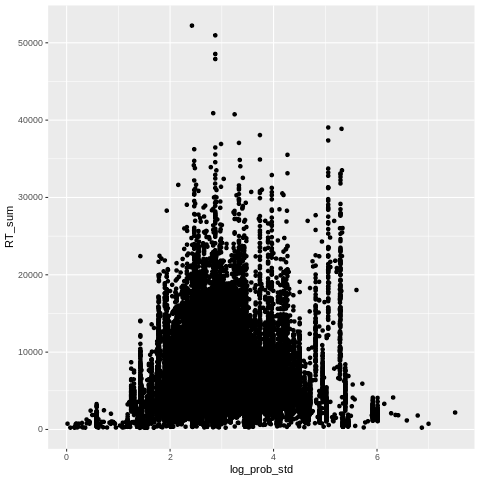

In [ ]:
%%R
library(ggplot2)
ggplot(aes(x = log_prob_std, y = RT_sum ), data=aggregate_per_sentence) + geom_point()

In [ ]:
import pickle
with open('probs_dict.pkl', 'rb') as handle:
    log_probs = pickle.load( handle)
len(log_probs)

10

# Fine-tuning a language model

In this notebook, we'll see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) model on a language modeling tasks. We will cover two types of language modeling tasks which are:

- Causal language modeling: the model has to predict the next token in the sentence (so the labels are the same as the inputs shifted to the right). To make sure the model does not cheat, it gets an attention mask that will prevent it to access the tokens after token i when trying to predict the token i+1 in the sentence.

![Widget inference representing the causal language modeling task](images/causal_language_modeling.png)

- Masked language modeling: the model has to predict some tokens that are masked in the input. It still has access to the whole sentence, so it can use the tokens before and after the tokens masked to predict their value.

![Widget inference representing the masked language modeling task](images/masked_language_modeling.png)

We will see how to easily load and preprocess the dataset for each one of those tasks, and how to use the `Trainer` API to fine-tune a model on it.

A script version of this notebook you can directly run on a distributed environment or on TPU is available in our [examples folder](https://github.com/huggingface/transformers/tree/master/examples).

## Preparing the dataset

For each of those tasks, we will use the [Wikitext 2]() dataset as an example. You can load it very easily with the 🤗 Datasets library.

In [ ]:
from datasets import load_dataset
datasets = load_dataset('wikitext', 'wikitext-2-raw-v1')

Dataset wikitext downloaded and prepared to /root/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/47c57a6745aa5ce8e16a5355aaa4039e3aa90d1adad87cef1ad4e0f29e74ac91. Subsequent calls will reuse this data.


You can replace the dataset above with any dataset hosted on [the hub](https://huggingface.co/datasets) or use your own files. Just uncomment the following cell and replace the paths with values that will lead to your files:

In [ ]:
# datasets = load_dataset("text", data_files={"train": path_to_train.txt, "validation": path_to_validation.txt}

You can also load datasets from a csv or a JSON file, see the [full documentation](https://huggingface.co/docs/datasets/loading_datasets.html#from-local-files) for more information.

To access an actual element, you need to select a split first, then give an index:

In [ ]:
datasets["train"][10]

{'text': ' The game \'s battle system , the BliTZ system , is carried over directly from Valkyira Chronicles . During missions , players select each unit using a top @-@ down perspective of the battlefield map : once a character is selected , the player moves the character around the battlefield in third @-@ person . A character can only act once per @-@ turn , but characters can be granted multiple turns at the expense of other characters \' turns . Each character has a field and distance of movement limited by their Action Gauge . Up to nine characters can be assigned to a single mission . During gameplay , characters will call out if something happens to them , such as their health points ( HP ) getting low or being knocked out by enemy attacks . Each character has specific " Potentials " , skills unique to each character . They are divided into " Personal Potential " , which are innate skills that remain unaltered unless otherwise dictated by the story and can either help or impede

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset.

In [ ]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(datasets["train"])

As we can see, some of the texts are a full paragraph of a Wikipedia article while others are just titles or empty lines.

## Causal Language modeling

For causal language modeling (CLM) we are going to take all the texts in our dataset and concatenate them after they are tokenized. Then we will split them in examples of a certain sequence length. This way the model will receive chunks of contiguous text that may look like:
```
part of text 1
```
or 
```
end of text 1 [BOS_TOKEN] beginning of text 2
```
depending on whether they span over several of the original texts in the dataset or not. The labels will be the same as the inputs, shifted to the left.

We will use the [`distilgpt2`](https://huggingface.co/distilgpt2) model for this example. You can pick any of the checkpoints listed [here](https://huggingface.co/models?filter=causal-lm) instead:

In [ ]:
model_checkpoint = "distilgpt2"

To tokenize all our texts with the same vocabulary that was used when training the model, we have to download a pretrained tokenizer. This is all done by the `AutoTokenizer` class:

In [ ]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

We can now call the tokenizer on all our texts. This is very simple, using the [`map`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.map) method from the Datasets library. First we define a function that call the tokenizer on our texts:

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"])

Then we apply it to all the splits in our `datasets` object, using `batched=True` and 4 processes to speed up the preprocessing. We won't need the `text` column afterward, so we discard it.

In [ ]:
tokenized_datasets = datasets.map(tokenize_function, batched=True, num_proc=4, remove_columns=["text"])

Loading cached processed dataset at /home/sgugger/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/47c57a6745aa5ce8e16a5355aaa4039e3aa90d1adad87cef1ad4e0f29e74ac91/cache-0a686d6f64cb210f.arrow
Loading cached processed dataset at /home/sgugger/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/47c57a6745aa5ce8e16a5355aaa4039e3aa90d1adad87cef1ad4e0f29e74ac91/cache-659bcb80cad0097c.arrow
Loading cached processed dataset at /home/sgugger/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/47c57a6745aa5ce8e16a5355aaa4039e3aa90d1adad87cef1ad4e0f29e74ac91/cache-7f22912475d34c88.arrow
Loading cached processed dataset at /home/sgugger/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/47c57a6745aa5ce8e16a5355aaa4039e3aa90d1adad87cef1ad4e0f29e74ac91/cache-b3566e2fe9c5c036.arrow
Loading cached processed dataset at /home/sgugger/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/47c57a6745aa5ce8e16a5355aaa4039e3aa90d1adad87cef1ad4e0f29e74ac91/cach

If we now look at an element of our datasets, we will see the text have been replaced by the `input_ids` the model will need:

In [ ]:
tokenized_datasets["train"][1]

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1],
 'input_ids': [796, 569, 18354, 7496, 17740, 6711, 796, 220, 198]}

Now for the harder part: we need to concatenate all our texts together then split the result in small chunks of a certain `block_size`. To do this, we will use the `map` method again, with the option `batched=True`. This option actually lets us change the number of examples in the datasets by returning a different number of examples than we got. This way, we can create our new samples from a batch of examples.

First, we grab the maximum length our model was pretrained with. This might be a big too big to fit in your GPU RAM, so here we take a bit less at just 128.

In [ ]:
# block_size = tokenizer.model_max_length
block_size = 128

Then we write the preprocessing function that will group our texts:

In [ ]:
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

First note that we duplicate the inputs for our labels. This is because the model of the 🤗 Transformers library apply the shifting to the right, so we don't need to do it manually.

Also note that by default, the `map` method will send a batch of 1,000 examples to be treated by the preprocessing function. So here, we will drop the remainder to make the concatenated tokenized texts a multiple of `block_size` every 1,000 examples. You can adjust this behavior by passing a higher batch size (which will also be processed slower). You can also speed-up the preprocessing by using multiprocessing:

In [ ]:
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=1000,
    num_proc=4,
)

Loading cached processed dataset at /home/sgugger/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/47c57a6745aa5ce8e16a5355aaa4039e3aa90d1adad87cef1ad4e0f29e74ac91/cache-da77bf362d4c6fa4.arrow
Loading cached processed dataset at /home/sgugger/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/47c57a6745aa5ce8e16a5355aaa4039e3aa90d1adad87cef1ad4e0f29e74ac91/cache-7d08a6d62516c9ff.arrow
Loading cached processed dataset at /home/sgugger/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/47c57a6745aa5ce8e16a5355aaa4039e3aa90d1adad87cef1ad4e0f29e74ac91/cache-a985b575c96ddae3.arrow
Loading cached processed dataset at /home/sgugger/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/47c57a6745aa5ce8e16a5355aaa4039e3aa90d1adad87cef1ad4e0f29e74ac91/cache-47fffef35acafddb.arrow
Loading cached processed dataset at /home/sgugger/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/47c57a6745aa5ce8e16a5355aaa4039e3aa90d1adad87cef1ad4e0f29e74ac91/cach

And we can check our datasets have changed: now the samples contain chunks of `block_size` contiguous tokens, potentially spanning over several of our original texts.

In [ ]:
tokenizer.decode(lm_datasets["train"][1]["input_ids"])

' game and follows the " Nameless ", a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven ". \n The game began development in 2010, carrying over a large portion of the work done on Valkyria Chronicles II. While it retained the standard features of the series, it also underwent multiple adjustments, such as making the game more forgiving for series newcomers. Character designer Raita Honjou and composer Hitoshi Sakimoto both returned from previous entries, along with Valkyria Chronicles II director Takeshi Oz'

Now that the data has been cleaned, we're ready to instantiate our `Trainer`. We will a model:

In [ ]:
from transformers import AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained(model_checkpoint)

And some `TrainingArguments`:

In [ ]:
from transformers import Trainer, TrainingArguments

In [ ]:
training_args = TrainingArguments(
    "test-clm",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
)

We pass along all of those to the `Trainer` class:

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["validation"],
)

And we can train our model:

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,3.767790,3.664047
2,3.648033,3.645540
3,3.594949,3.641928


TrainOutput(global_step=7002, training_loss=3.69408126695944)

Once the training is completed, we can evaluate our model and get its perplexity on the validation set like this:

In [ ]:
import math
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

Perplexity: 38.17


## Masked language modeling

For masked language modeling (MLM) we are going to use the same preprocessing as before for our dataset with one additional step: we will randomly mask some tokens (by replacing them by `[MASK]`) and the labels will be adjusted to only include the masked tokens (we don't have to predict the non-masked tokens).

We will use the [`distilroberta-base`](https://huggingface.co/distilroberta-base) model for this example. You can pick any of the checkpoints listed [here](https://huggingface.co/models?filter=masked-lm) instead:

In [ ]:
model_checkpoint = "distilroberta-base"

We can apply the same tokenization function as before, we just need to update our tokenizer to use the checkpoint we just picked:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)
tokenized_datasets = datasets.map(tokenize_function, batched=True, num_proc=4, remove_columns=["text"])

Loading cached processed dataset at /home/sgugger/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/47c57a6745aa5ce8e16a5355aaa4039e3aa90d1adad87cef1ad4e0f29e74ac91/cache-333e4baa6f280a66.arrow
Loading cached processed dataset at /home/sgugger/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/47c57a6745aa5ce8e16a5355aaa4039e3aa90d1adad87cef1ad4e0f29e74ac91/cache-23acd0930cc16da7.arrow
Loading cached processed dataset at /home/sgugger/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/47c57a6745aa5ce8e16a5355aaa4039e3aa90d1adad87cef1ad4e0f29e74ac91/cache-56ae8ad41a9fdf19.arrow
Loading cached processed dataset at /home/sgugger/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/47c57a6745aa5ce8e16a5355aaa4039e3aa90d1adad87cef1ad4e0f29e74ac91/cache-599a47a0e666ad65.arrow
Loading cached processed dataset at /home/sgugger/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/47c57a6745aa5ce8e16a5355aaa4039e3aa90d1adad87cef1ad4e0f29e74ac91/cach

And like before, we group texts together and chunk them in samples of length `block_size`. You can skip that step if your dataset is composed of individual sentences.

In [ ]:
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=1000,
    num_proc=4,
)

Loading cached processed dataset at /home/sgugger/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/47c57a6745aa5ce8e16a5355aaa4039e3aa90d1adad87cef1ad4e0f29e74ac91/cache-661796332aa2b576.arrow
Loading cached processed dataset at /home/sgugger/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/47c57a6745aa5ce8e16a5355aaa4039e3aa90d1adad87cef1ad4e0f29e74ac91/cache-e019d91824c225fd.arrow
Loading cached processed dataset at /home/sgugger/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/47c57a6745aa5ce8e16a5355aaa4039e3aa90d1adad87cef1ad4e0f29e74ac91/cache-b5875c725d0e5cb7.arrow
Loading cached processed dataset at /home/sgugger/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/47c57a6745aa5ce8e16a5355aaa4039e3aa90d1adad87cef1ad4e0f29e74ac91/cache-a8e3eeaa703ca023.arrow
Loading cached processed dataset at /home/sgugger/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/47c57a6745aa5ce8e16a5355aaa4039e3aa90d1adad87cef1ad4e0f29e74ac91/cach

The rest is very similar to what we had, with two exceptions. First we use a model suitable for masked LM:

In [ ]:
from transformers import AutoModelForMaskedLM
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


And second, we use a special `data_collator`. The `data_collator` is a function that is responsible of taking the samples and batching them in tensors. In the previous example, we had nothing special to do, so we just used the default for this argument. Here we want to do the random-masking. We could do it as a pre-processing step (like the tokenization) but then the tokens would always be masked the same way at each epoch. By doing this step inside the `data_collator`, we ensure this random masking is done in a new way each time we go over the data.

To do this masking for us, the library provides a `DataCollatorForLanguageModeling`. We can adjust the probability of the masking:

In [ ]:
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

Then we just have to pass everything to `Trainer` and begin training:

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["validation"],
    data_collator=data_collator,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.109144,1.919501
2,1.986566,1.884295
3,1.952879,1.861102


TrainOutput(global_step=7218, training_loss=2.0377309222603213)

Like before, we can evaluate our model on the validation set. The perplexity is much lower than for the CLM objective because for the MLM objective, we only have to make predictions for the masked tokens (which represent 15% of the total here) while having access to the rest of the tokens. It's thus an easier task for the model.

In [ ]:
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

Perplexity: 6.37


Don't forget to [update your model](https://huggingface.co/transformers/model_sharing.html) on the [🤗 Model Hub](https://huggingface.co/models). You can then use it only to generate results like the one shown in the first picture of this notebook!|